In [1]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy import integrate

In [2]:
def phi(x, beta):
    ones = torch.ones(x.shape) # n x 1
    new_x = torch.hstack((x, ones)) #n x 2
    result = torch.sum(new_x *beta, axis=1) #n x 1
    return torch.clamp(result.reshape(-1, 1), min=0.) #n x 1

def allocation(x, beta, dist_mean, budget):
    denom = dist_mean
    res = (phi(x, beta)/(denom+ 1e-5)) * budget
    return res

def get_dist_mean(x, beta):
    phis  = phi(x, beta)
    return torch.sum(phis)


In [3]:
def policy_loss(w, theta):
    return torch.pow(w - theta, 2)

def gaming_cost(theta, theta_prime, game_weight=0.5):
    return torch.pow(theta-theta_prime, 2) * game_weight
    #return 0.

def get_agent_features(theta, theta_tilde, beta, dist_mean, budget):
    no_gaming_cost = theta - allocation(theta, beta, dist_mean, budget) + gaming_cost(theta, theta)
    g_cost = theta - allocation(theta_tilde, beta, dist_mean, budget) + gaming_cost(theta, theta_tilde)
    cost_table = torch.hstack((no_gaming_cost, g_cost))
    idx = torch.argmin(cost_table, axis=1)
    new_features = theta.clone()
    new_features[torch.where(idx == 1)] = theta_tilde.clone()[torch.where(idx==1)]
    prop_gaming=torch.sum(idx)/idx.shape[0]

    return new_features, prop_gaming

In [4]:
def agent_loss(w, theta, x):
    return theta - w + gaming_cost(theta, x)

## Algorithm
1. Decision-maker announces rule $\beta^{t}$ and $E_{y\sim p^{t-1}}[y]$.
2. Agents chooses which features to play $x^{t}$.
3. $x^{t}$'s form the new population distribution $p^{t}.$
4. Decision-maker gives out allocations according to $\beta^{t}$ and $p^{t}$. Agents incur loss.
5. Decision-maker creates an updated rule $\beta^{t+1}.$

In [5]:
torch.manual_seed(0)
n= 10000
theta = torch.rand(n, 1)
theta_tilde = theta + 0.5
beta = torch.Tensor([[1, 0]])
T = 10000
h = 0.001
eta = 0.01

In [6]:
agent_losses = torch.zeros(T, n)
policy_losses = torch.zeros(T, n)
betas = torch.zeros(T, 2)
dists = []
prop_gaming = []

x = theta
dist_mean = get_dist_mean(theta, beta)
budget = dist_mean.clone()
exp_name = "slope_and_intercept"
for i in tqdm(range(T)):
    dists.append(dist_mean.item())
    betas[i] = beta.clone()
    perturbation = torch.bernoulli(torch.ones(n, 2) * 0.5)
    perturbation[perturbation==0.] = -1
    perturbation = perturbation * h
    beta_perturbed = beta.clone().repeat(n, 1) + perturbation
    x, p_game = get_agent_features(theta, theta_tilde, beta_perturbed, dist_mean, budget)
    prop_gaming.append(p_game)
    
    #compute dist mean
    dist_mean = get_dist_mean(x, beta)
    w = allocation(x, beta, dist_mean, budget)
    agent_losses[i] = agent_loss(w, theta, x).flatten()
    p_loss = policy_loss(w, theta)
    policy_losses[i] = p_loss.flatten()
    #gamma = torch.matmul(perturbation.T, p_loss)/(torch.matmul(perturbation.T, perturbation))
    gamma, _ = torch.solve(torch.matmul(perturbation.T, p_loss), torch.matmul(perturbation.T, perturbation)) 
    beta -= eta * gamma.flatten()
    
    

100%|██████████| 10000/10000 [01:12<00:00, 138.55it/s]


In [7]:
exp_name = "slope_and_intercept_0"

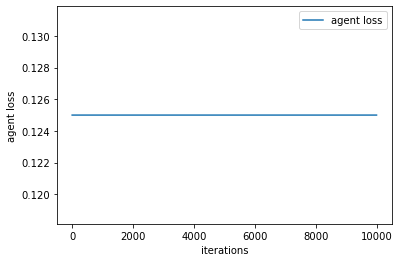

In [8]:
plt.plot(list(range(T)), torch.mean(agent_losses, axis=1).numpy().round(3), label="agent loss")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("agent loss")
plt.savefig("figs/{}/agent_loss.pdf".format(exp_name))

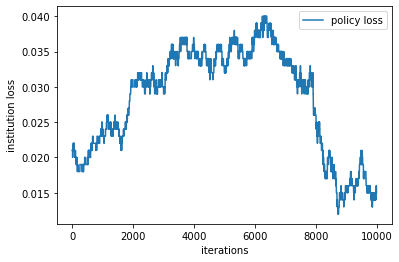

In [9]:
plt.plot(list(range(T)), torch.mean(policy_losses, axis=1).numpy().round(3), label="policy loss")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("institution loss")
plt.savefig("figs/{}/policy_loss.pdf".format(exp_name))

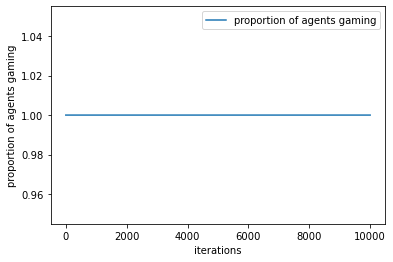

In [10]:
plt.plot(list(range(len(prop_gaming))), prop_gaming, label="proportion of agents gaming")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("proportion of agents gaming")
plt.savefig("figs/{}/prop_gaming_loss.pdf".format(exp_name))

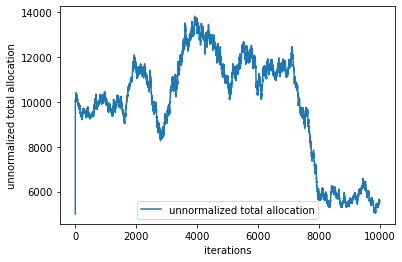

In [11]:
plt.plot(list(range(len(dists))), [round(i, 3) for i in dists], label="unnormalized total allocation")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("unnormalized total allocation")
plt.savefig("figs/{}/unnormalized_allocation.pdf".format(exp_name))

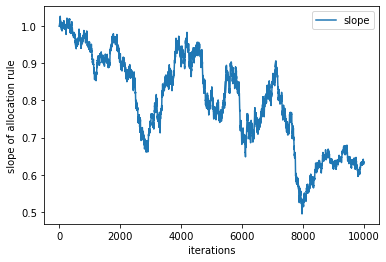

In [12]:
plt.plot(list(range(T)), betas[:, 0], label="slope")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("slope of allocation rule")
plt.savefig("figs/{}/slope.pdf".format(exp_name))

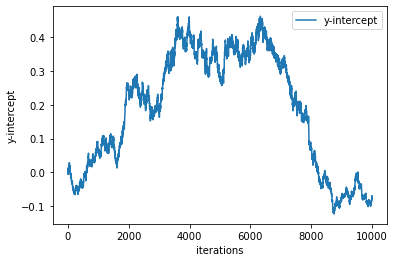

In [13]:
plt.plot(list(range(T)), betas[:, 1], label="y-intercept")
plt.xlabel("iterations")
plt.ylabel("y-intercept")
plt.legend()
plt.savefig("figs/{}/intercept.pdf".format(exp_name))

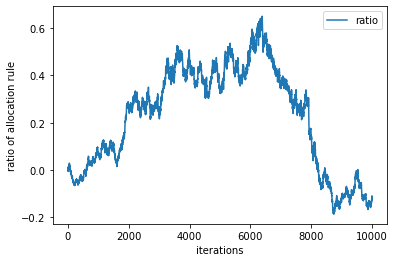

In [14]:
plt.plot(list(range(T)), betas[:, 1]/betas[:, 0] , label="ratio")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("ratio of allocation rule")
plt.savefig("figs/{}/ratio.pdf".format(exp_name))